## Translating Japanese text to English using attention enabled Encoder-Decoder model.

### 🤔 What is Attention mechanism?
#### Before understanding the attention mechanism, first let's take a quick look at Encoder-Decoder architecture.

### 𝌭 Encoder-Decoder model:
![encoder decoder image](https://queirozf.com/images/contents/ZZqXAUp.png)

#### The Encoder-Decoder architecture with recurrent neural networks has become an effective and standard approach for both neural machine translation (NMT) and sequence-to-sequence (seq2seq) prediction in general. The key benefits of the approach are the ability to train a single end-to-end model directly on source and target sentences and the ability to handle variable length input and output sequences of text.
#### An Encoder-Decoder architecture was developed where an input sequence was read in entirety and encoded to a *fixed-length internal representation*. A decoder network then used this internal representation to output words until the end of sequence token was reached. LSTM networks were used for both the encoder and decoder.
#### It works fairly well but without attention the performance drops as the length of the sentences increase.
![bleu score encoder-decoder](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/10/Loss-in-model-skill-with-increased-sentence-length.png)

### ⁉️ Attention model:
#### Attention is a mechanism that was developed to improve the performance of the Encoder-Decoder RNN on machine translation. It was proposed as a solution to the limitation of the Encoder-Decoder model encoding the input sequence to one *fixed length internal representation* from which to decode each output time step. This issue was believed to be more of a problem when decoding long sequences. Instead of encoding the input sequence into a single fixed context vector, the attention model develops a context vector that is filtered specifically for each output time step.
#### As with the Encoder-Decoder paper, the technique is applied to a machine translation problem and uses GRU units rather than LSTM memory cells. But in this project I'll be using LSTM memory cells.


### 🕵 How do Attention models work?
#### Since the attention models are encoder-decoder models with attention mechanism, they function very similar to encoder-decoder models but with a catch. Given a problem of generating an output text sequence from input text sequence (Ex. converting a Japanese sentence to English), let's quickly go through the working of a encoder decoder model step by step:
1. Encoding: The input sentence is first encoded as a single fixed-length vector.
2. Score calculation: The encoded input sentence flows through the encoder and decoder. The decoder outputs one value at a time, which is passed on to perhaps more layers before finally outputting a prediction (y) for the current output time step. The alignment model scores (e) how well each encoded input (h) matches the current output of the decoder (s). The calculation of the score requires the output from the decoder from the previous output time step, e.g. s(t-1). When scoring the very first output for the decoder, this will be 0. Scoring is performed using a **function a()**.
3. Annotation weights calculation: Next, the alignment scores are normalized using a softmax function. The normalization of the scores allows them to be treated like probabilities, indicating the likelihood of each encoded input time step (annotation) being relevant to the current output time step. These normalized scores are called annotation weights.
4. Context-vector calculation: Next, each annotation (h) is multiplied by the annotation weights (a) to produce a new attended context vector from which the current output time step can be decoded.
5. Decoding: Decoding is then performed as per the Encoder-Decoder model, although in this case using the attended context vector for the current time step.

Find the original paper here: https://arxiv.org/abs/1706.03762

### Let's get started straight away!

In [1]:
# installing japanese font
from matplotlib.font_manager import FontProperties
!apt-get -y install fonts-ipafont-gothic
font_jp = FontProperties(fname=r'/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf',size=10)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 70 not upgraded.
Need to get 8251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4725 kB]
Fetched 8251 kB in 3s (2434 kB/s)              
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 113054 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-18ubuntu1_all.deb ...
Unpacking fonts-ip

In [2]:
# Importing the necessary libraries.
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu as bleu
from janome.tokenizer import Tokenizer as janome_tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TimeDistributed , LSTM
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import warnings
import time
import re
import os
# warnings.filterwarnings("ignore", message="Glyph \d+ missing from current font.")
warnings.simplefilter("ignore")
sns.set()


In [3]:
f = open('../input/english-to-japanese-50k-sentences/jpn.txt').read() # reading data from file
data_ = [line.split('\t')[:2] for line in f.split('\n')[:-1]] # removing attribution
df = pd.DataFrame(data_, columns=['English', 'Japanese'])
print('Dimensions of the data as a dataframe:')
df.shape

Dimensions of the data as a dataframe:


(53594, 2)

In [4]:
df.head(10)

,English,Japanese
0,Go.,行け。
1,Go.,行きなさい。
2,Hi.,こんにちは。
3,Hi.,もしもし。
4,Hi.,やっほー。
5,Hi.,こんにちは！
6,Run.,走れ。
7,Run.,走って！
8,Who?,誰？
9,Wow!,すごい！


In [5]:
df.tail(10)

,English,Japanese
53584,The National Center for Education Information ...,全国教育情報センターによれば、退職した教員が復職しているおかげで、予測された教員不足は起こら...
53585,The people here are particular about what they...,ここの人たちは舌が肥えていますから、安くてもまずい店はすぐにつぶれてしまうんですよ。
53586,If a person has not had a chance to acquire hi...,大人になるまでの間に身につけなかった言語について、ネイティブスピーカーのレベルに達することは...
53587,"Even at the end of the nineteenth century, sai...",１９世紀末でも、イギリス海軍の船員は、そうすることが弱さの印だという理由で、ナイフとフォーク...
53588,"Tom said, ""You can kiss your girlfriend goodby...",「恋人にさよならのキスくらいしないと、キスしてあばよ、ということになるぞ」とトムは言ったが、...
53589,Five tremors in excess of magnitude 5.0 on the...,日本ではリヒター・スケールでマグニチュード5.0以上の余震が今週5回ありました。しかし科学者...
53590,The bus now arriving is going to Domestic Term...,ただ今到着のバスは、国内線第1ターミナル行きです。国際線ターミナルにお越しの方は、しばらくそ...
53591,A child who is a native speaker usually knows ...,ネイティブの子どもは、何年も学んだ非ネイティブが知らず今後も知り得ないたくさんのことを自身の...
53592,"I do many things at the same time, so not only...",色々並行してやってるから芥川ばかり読んでるのでもないのだよ。今は英語読んでる時間が増えてる。...
53593,If someone who doesn't know your background sa...,生い立ちを知らない人にネイティブみたいに聞こえるよって言われたら、それはおそらく、あなたの喋...


In [6]:
# For tokenizing the Japanese sentences
from janome.tokenizer import Tokenizer as janome_tokenizer
token_object = janome_tokenizer()

### 🧹 Data preprocessing

In [37]:
mispell_dict = {"aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", 
                "couldnt" : "could not", "didn't" : "did not", "doesn't" : "does not", 
                "doesnt" : "does not", "don't" : "do not", "hadn't" : "had not", 
                "hasn't" : "has not", "haven't" : "have not", "havent" : "have not", 
                "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would",
                "i'd" : "I had", "i'll" : "I will", "i'm" : "I am", "isn't" : "is not", 
                "it's" : "it is", "it'll":"it will", "i've" : "I have", "let's" : "let us", 
                "mightn't" : "might not", "mustn't" : "must not", "shan't" : "shall not", 
                "she'd" : "she would", "she'll" : "she will", "she's" : "she is", 
                "shouldn't" : "should not", "shouldnt" : "should not", "that's" : "that is", 
                "thats" : "that is", "there's" : "there is", "theres" : "there is", 
                "they'd" : "they would", "they'll" : "they will", "they're" : "they are", 
                "theyre": "they are", "they've" : "they have", "we'd" : "we would", 
                "we're" : "we are", "weren't" : "were not", "we've" : "we have", 
                "what'll" : "what will", "what're" : "what are", "what's" : "what is", 
                "what've" : "what have", "where's" : "where is", "who'd" : "who would",
                "who'll" : "who will", "who're" : "who are", "who's" : "who is", 
                "who've" : "who have", "won't" : "will not", "wouldn't" : "would not", 
                "you'd" : "you would", "you'll" : "you will", "you're" : "you are", 
                "you've" : "you have", "'re": " are", "wasn't": "was not", "we'll":" will", 
                "didn't": "did not", "tryin'":"trying"
                }

def deconcate(sent):
    keys = mispell_dict.keys()
    cleaned_sentence = []
    for word in sent.split(' '):
        if word in keys:
            cleaned_sentence.append(mispell_dict[word])
        else:
            cleaned_sentence.append(word)
    return ' '.join(cleaned_sentence)

In [38]:
def preprocess(phrase):
  phrase = phrase.strip().lower()
  phrase = deconcate(phrase)
  phrase = '<sos> '+ phrase.lower() +' <eos>'
  return phrase

In [41]:
# preprocessing the sentences by stripping and adding <sos>, <eos>
english, japanese = [], []
for line in tqdm(f.split('\n')[:-1]):
  english.append(preprocess(line.split('\t')[0]))
  jp_ = ' '.join([x.surface for x in token_object.tokenize(line.split('\t')[1])])
  japanese.append(preprocess(jp_))

### 📊 Let's do some analysis on the sentence lengths.

In [43]:
_eng_len = [len(x.split(' '))-2 for x in english]
_jpn_len = [len(x.split(' '))-2 for x in japanese]

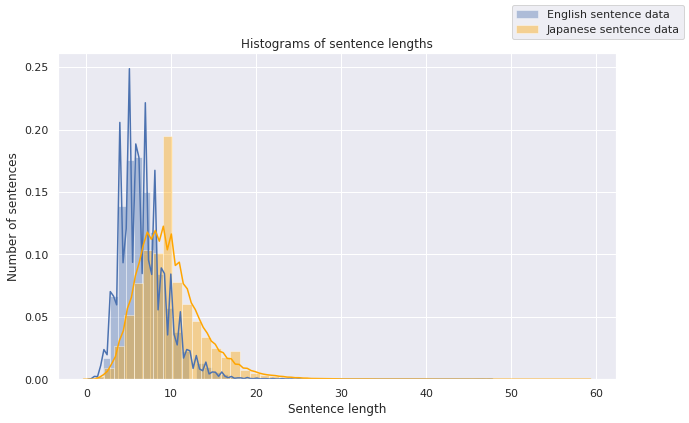

In [44]:
sns.set()
fig = plt.figure(figsize=(10,6))
sns.distplot(_eng_len)
sns.distplot(_jpn_len, color='orange')
fig.legend(labels=['English sentence data','Japanese sentence data'])
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Histograms of sentence lengths')
plt.show()

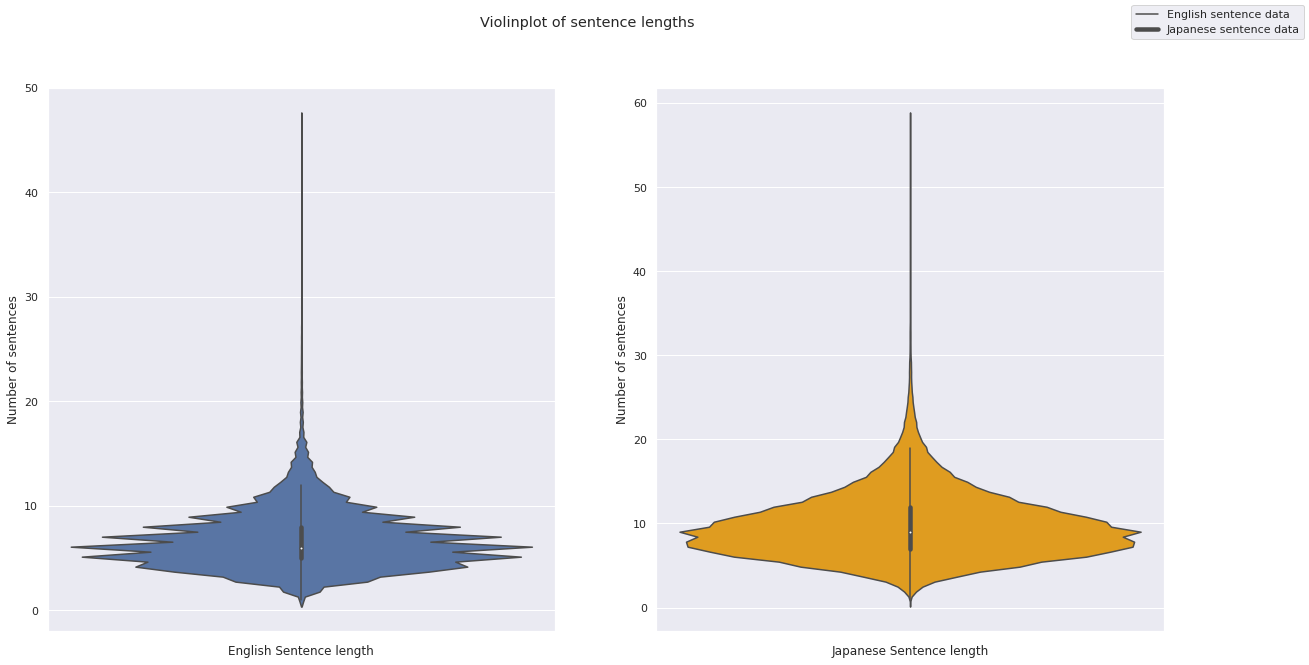

In [45]:
fig, ax = plt.subplots(1,2, figsize=(20, 10))
sns.violinplot(_eng_len, ax=ax[0], orient='v')
fig.suptitle('Violinplot of sentence lengths')
ax[0].set_xlabel('English Sentence length')
ax[0].set_ylabel('Number of sentences')
sns.violinplot(_jpn_len, ax=ax[1], orient='v', color='orange')
ax[1].set_xlabel('Japanese Sentence length')
ax[1].set_ylabel('Number of sentences')
fig.legend(labels=['English sentence data','Japanese sentence data'])
plt.show();

#### Hmmm... The Japanese sentences tend to have a longer word length than the English sentences.

In [46]:
# initializing tokenizer To convert the words into numerical representation
filters = "+1234567890\"#$%&()*+,-/:;=@[\\]^_`{|}~'"
tokenizer_eng = Tokenizer(split=' ', char_level=False, filters=filters)
# fitting on english
tokenizer_eng.fit_on_texts(english)
eng_tokens = tokenizer_eng.texts_to_sequences(english)
# fitting on japanese
tokenizer_jpn = Tokenizer(lower=True, split=' ', char_level=False, filters=filters)
tokenizer_jpn.fit_on_texts(japanese)
jpn_tokens = tokenizer_jpn.texts_to_sequences(japanese)

In [47]:
# defining the vocabulary size of english and japanese language in the given data.
eng_vocab = len(tokenizer_eng.word_index.items()) + 1
jpn_vocab = len(tokenizer_jpn.word_index.items()) + 1

In [48]:
# defining the max length of english and japanese sentence in the given data (for padding).
eng_max = max([len(e) for e in eng_tokens])
jpn_max = max([len(i) for i in jpn_tokens])

In [49]:
# Padding the tokenized data
eng_padded = pad_sequences(eng_tokens, maxlen=eng_max, padding='post')
jpn_padded = pad_sequences(jpn_tokens, maxlen=jpn_max, padding='post')

In [50]:
# splitting data into train and test
eng_tr, eng_te, jpn_tr, jpn_te = train_test_split(eng_padded, jpn_padded, test_size=0.03, random_state=42)

In [51]:
eng_tr.shape, jpn_tr.shape, eng_te.shape, jpn_te.shape

((51986, 49), (51986, 60), (1608, 49), (1608, 60))

### ⌸ General method for score calculation.
#### Defining the encoder and decoder models

In [52]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = enc_units
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, name="embedding_layer_encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True,
                             recurrent_initializer='glorot_uniform', name="Encoder_LSTM")
        
    def call(self, input_sentances, state_h, state_c, training=True):
        input_embedd = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h, self.state_c = self.lstm(input_embedd, initial_state=[state_h, state_c])
        return self.lstm_output, self.lstm_state_h

    def initialize_hidden_state(self, batch_sz):
        return [tf.zeros((batch_sz, self.enc_units)), tf.zeros((batch_sz, self.enc_units))]
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.dense = tf.keras.layers.Dense(vocab_size)
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, name="embedding_layer_decoder")
        self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True,
                             recurrent_initializer='glorot_uniform', name="Encoder_LSTM")
        
    def call(self, target_sentances, enc_output, state_h):
        target_embedd = self.embedding(target_sentances)
        # concat method as content-based function
        hidden_with_time_axis = tf.expand_dims(state_h, 1) # expanding layer dimension for compatibility with encoder_output tensor
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))) # calculating score
        attention_weights = tf.nn.softmax(score, axis=1) # calculating attention_weights
        context_vector = attention_weights * enc_output # calculating context_vector
        context_vector = tf.reduce_sum(context_vector, axis=1) # preparing context vector to make it compatible with target_embedd
        target_embedd = tf.concat([tf.expand_dims(context_vector, 1), target_embedd], axis=-1) # concatenating context vector and target_embeddings
        lstm_output, state_h, state_c = self.lstm(target_embedd) # getting result from lstm
        lstm_output = tf.reshape(lstm_output, (-1, lstm_output.shape[2])) # Making the output compatible for dense layer for (vocab representation)
        dec_output = self.dense(lstm_output) # getting vocab size output
        return  attention_weights, dec_output, state_h, attention_weights

    def initialize_hidden_state(self, batch_sz):
        return [tf.zeros((batch_sz, self.enc_units)), tf.zeros((batch_sz, self.enc_units))]

### 📉 Defining the loss function

In [53]:
optimizer = tf.keras.optimizers.Adam()
def loss_function(real, pred):
    mask = tf.cast(tf.cast(real, dtype=tf.bool), dtype=tf.float32) #mask to elemenate the loss due <pad> values
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

### ⒡ BLEU score function

In [54]:
# https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
warnings.simplefilter("ignore")
# I'll be calculating the BLEU score in 1000 random datapoints from test data.
def bleu_score_calc(encoder, decoder):
    size = 1000
    pts = np.random.randint(0, jpn_te.shape[0], size)
    q = jpn_te[pts]
    questions = [t.split(' ')[1:-1] for t in tokenizer_jpn.sequences_to_texts(q)]

    a = eng_te[pts]
    answers = [t.split(' ')[1:-1] for t in tokenizer_eng.sequences_to_texts(a)]

    inputs = tf.convert_to_tensor(q)
    
    state_h, state_c = [tf.zeros((size, units)), tf.zeros((size, units))]
    encoder_output, state_h = encoder(inputs, state_h, state_c)
    decoder_input = tf.expand_dims(tokenizer_jpn.texts_to_sequences(['<sos>'])[0]*size, 1)
    
    result = []
    for i in range(eng_max):
      attention_wts, decoder_output, state_h, _ = decoder(decoder_input, encoder_output, state_h)
      predicted_word = tf.argmax(decoder_output, axis=1).numpy()
      result.append(tokenizer_eng.sequences_to_texts(predicted_word.reshape(-1,1)))
      decoder_input = tf.expand_dims(predicted_word, 1)
    result = np.array(result).T
    guesses = [x[:np.where(x=='<eos>')[0][0]] if ('<eos>' in x) else x for x in result]

    return np.mean([bleu([x],y) for x,y in zip(answers, guesses)])

### 📈 Function for plotting the heatmap of Annotation weights

In [55]:
font_jp = FontProperties(fname=r'/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf',size=10)
def plot_heatmap(df):
  plt.figure(figsize=(16,10))
  plt.title('heatmap of Annotation weights')
  heatmap = plt.pcolor(df)

  for y in range(df.shape[0]):
      for x in range(df.shape[1]):
          plt.text(x + 0.5, y + 0.5, '%.3f' % df.values[y, x],
                  horizontalalignment='center',
                  verticalalignment='center')

  plt.colorbar(heatmap)
  plt.yticks(np.arange(0.5, len(df.index), 1), df.index, fontproperties=font_jp)
  plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, fontproperties=font_jp)
  plt.show()

In [56]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

### 🧮 Gradient calculation and update

In [57]:
# Calculation and applying gradient descent on the trainable parameters of the model
@tf.function
def train_step(encoder, decoder, state_h, state_c, inputs, target):
    loss = 0
    with tf.GradientTape() as tape:
        encoder_output, state_h = encoder(inputs, state_h, state_c)
        decoder_input = tf.expand_dims(tokenizer_jpn.texts_to_sequences(['<sos>'])[0] * BATCH_SIZE, 1)
        for t in range(1, target.shape[1]):
            attention_wts, decoder_output, state_h, score = decoder(decoder_input, encoder_output, state_h)
            loss += loss_function(target[:, t], decoder_output)
            decoder_input = tf.expand_dims(target[:, t], 1)
    
    batch_loss = (loss / int(target.shape[1]))
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(batch_loss)
    v_name = []
    for v in variables:
      v_name.append(v.name)

    return batch_loss, v_name, gradients

### ㊟ Creating Attention model

In [63]:
# https://www.tensorflow.org/tutorials/text/nmt_with_attention
class MyModel(Model):
    def __init__(self, jpn_vocab, eng_vocab, embedding_dim, units):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(jpn_vocab, embedding_dim, units)
        self.decoder = Decoder(eng_vocab, embedding_dim, units)
        self.optimizer = tf.keras.optimizers.Adam()
        self.state_h = 0
        self.state_c = 0
        self.batch_loss = 0
    
    def fit(self, dataset, BATCH_SIZE, epochs):
        tf.summary.trace_on(graph=True, profiler=False)
        for epoch in range(epochs):
            start = time.time()
            total_loss = 0
            self.state_h, self.state_c = self.encoder.initialize_hidden_state(BATCH_SIZE)
            for (batch, (inputs, target)) in enumerate(dataset):
                batch_loss, variables, gradients = train_step(self.encoder, self.decoder, self.state_h, self.state_c, inputs, target)
                total_loss += batch_loss
                if batch % 100 == 0:
                    print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

            bleu_score = bleu_score_calc(self.encoder, self.decoder)

            print('Epoch {} Loss {:.4f} BLEU-score {}'.format(epoch+1, total_loss/N_BATCH, bleu_score))
            print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

        tf.summary.trace_off()
        print('training completed...!')
        print('returning gradients...')
        train_loss.reset_states()

    # function for translating the input japanese sentence to english and plotting the annotation/attention scores.
    # If no sentence is passed, it picks a random sentence from Japanese test data
    def test(self, input_sentence=''):
        if input_sentence=='':
          k = np.random.randint(len(jpn_te)) # a random number
          w = jpn_te[k] # a random sentence sequence from the input language
          asked = tokenizer_jpn.sequences_to_texts([w])[0] # converting the input sequence into text
          print(f"input sentence: {' '.join(asked.split(' ')[1:-1])}") # printing the input text sequence

          o = eng_te[k] # a random sentence sequence from the output language
          o = tokenizer_eng.sequences_to_texts([o])[0] # converting the output sequence into text
          print(f"actual translation: {' '.join(o.split(' ')[1:-1])}") # printing the output text sequence
        
        else:
          inp = ' '.join([x.surface for x in token_object.tokenize(input_sentence)])
          prep = preprocess(inp)
          jp_tkn = tokenizer_jpn.texts_to_sequences([prep])
          w = pad_sequences(jp_tkn, maxlen=jpn_max, padding='post')[0]
          asked = tokenizer_jpn.sequences_to_texts([w])[0] # converting the input sequence into text
          print(f"input sentence: {' '.join(asked.split(' ')[1:-1])}") # printing the input text sequence

        # preparing input for attention model
        inputs = tf.convert_to_tensor(w.reshape(1,-1)) # initializing the input as a tensor
        state_h, state_c = [tf.zeros((1, units)), tf.zeros((1, units))] # initializing the hidden layers (all zeros)
        encoder_output, state_h = self.encoder(inputs, state_h, state_c)
        decoder_input = tf.expand_dims(tokenizer_jpn.texts_to_sequences(['<sos>'])[0], 0) # decoder initial input as all <sos>
        # translating sentence
        attention = []
        result = ''
        for i in range(eng_max):
          attention_wts, decoder_output, state_h, _ = self.decoder(decoder_input, encoder_output, state_h)
          attention_wts = attention_wts.numpy().flatten()
          predicted_word = tf.argmax(decoder_output[0]).numpy()
          if predicted_word == tokenizer_jpn.texts_to_sequences(['<eos>'])[0][0]:
            break
          result += tokenizer_eng.sequences_to_texts([[predicted_word]])[0] + ' '
          decoder_input = tf.expand_dims([predicted_word], 0)
          attention.append(attention_wts[1:len(asked.split(' '))-1])
        print(f'predicted translation: {result}')

        attention = np.array(attention)
        index = result.split(' ')[:-1]
        columns = asked.split(' ')[1:-1]

        atten = pd.DataFrame(attention, columns=columns, index=index)
        plot_heatmap(atten)

### 🏋 Defining some more parameters and training the model

In [64]:
BUFFER_SIZE = len(eng_tr)
BATCH_SIZE = 128
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
EPOCHS = 20
print(N_BATCH)

dataset = tf.data.Dataset.from_tensor_slices((jpn_tr, eng_tr)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

406


In [65]:
tf.keras.backend.clear_session()
model = MyModel(jpn_vocab, eng_vocab, embedding_dim, units)
model.fit(dataset, BATCH_SIZE, EPOCHS)
# model.save_weights('jpn_to_eng.h5')

Epoch 1 Batch 0 Loss 1.5596
Epoch 1 Batch 100 Loss 1.0024
Epoch 1 Batch 200 Loss 0.8508
Epoch 1 Batch 300 Loss 0.7947
Epoch 1 Batch 400 Loss 0.7298
Epoch 1 Loss 0.8675 BLEU-score 0.2534016888914495
Time taken for 1 epoch 347.7627990245819 sec

Epoch 2 Batch 0 Loss 0.7340
Epoch 2 Batch 100 Loss 0.6935
Epoch 2 Batch 200 Loss 0.6292
Epoch 2 Batch 300 Loss 0.6746
Epoch 2 Batch 400 Loss 0.5876
Epoch 2 Loss 0.6567 BLEU-score 0.39924591504830653
Time taken for 1 epoch 300.58339858055115 sec

Epoch 3 Batch 0 Loss 0.5594
Epoch 3 Batch 100 Loss 0.5661
Epoch 3 Batch 200 Loss 0.5353
Epoch 3 Batch 300 Loss 0.5417
Epoch 3 Batch 400 Loss 0.5047
Epoch 3 Loss 0.5394 BLEU-score 0.43674644864524015
Time taken for 1 epoch 300.69941210746765 sec

Epoch 4 Batch 0 Loss 0.4458
Epoch 4 Batch 100 Loss 0.4719
Epoch 4 Batch 200 Loss 0.4385
Epoch 4 Batch 300 Loss 0.4558
Epoch 4 Batch 400 Loss 0.4674
Epoch 4 Loss 0.4469 BLEU-score 0.4648632096627349
Time taken for 1 epoch 300.24699902534485 sec

Epoch 5 Batch 0 Los

### 💁🏻 It took around 100 mins to train the model on around 52k sentences and the BLEU score so far is 0.53 which is pretty good. Let's test the model on some random datapoints from the test data and check the attention scores.

input sentence: トム は 誰か 別 の 人 に それ を やる よう に お願い し た 。
actual translation: tom asked somebody else to do it.
predicted translation: tom asked someone else to do it. 


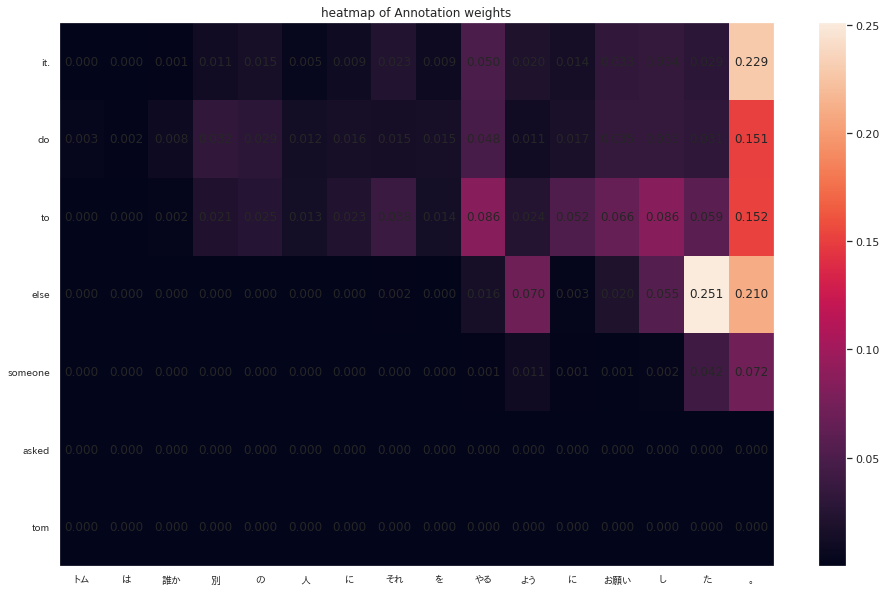

In [66]:
model.test()

input sentence: 私 に 怒ら ない で 。
actual translation: do not be mad at me.
predicted translation: do not be angry. 


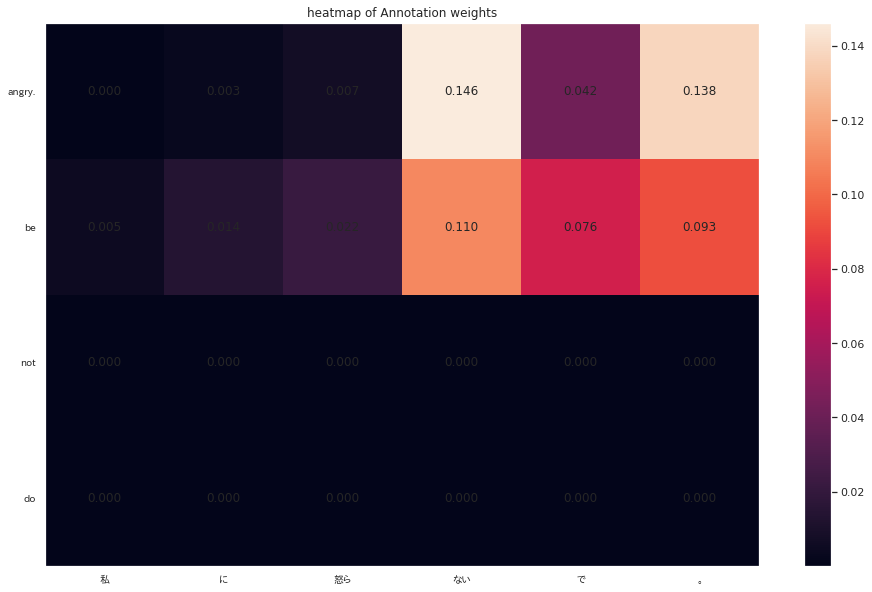

In [70]:
model.test()

input sentence: 久しぶり だ ね 。
actual translation: it is been a while since we last met.
predicted translation: it is been a long time. 


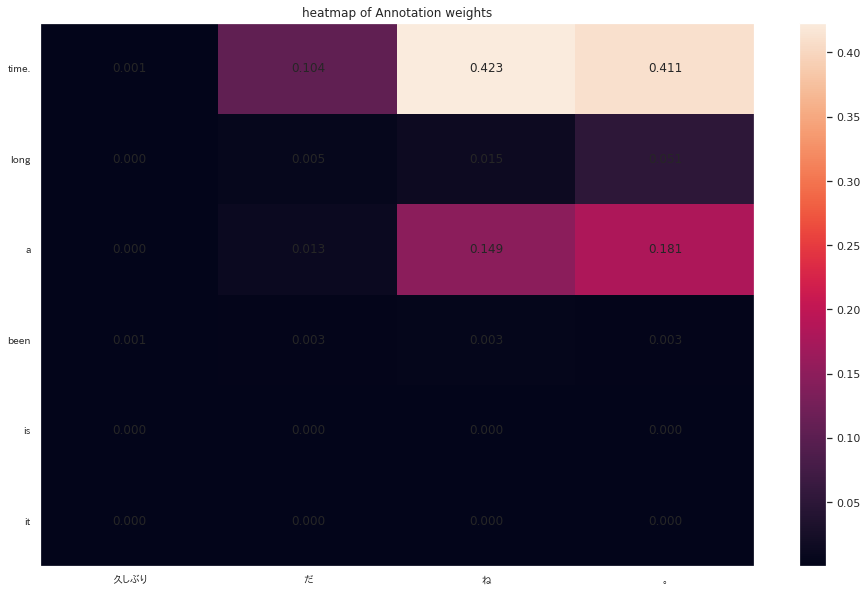

In [73]:
model.test()

### 💁🏻 The heatmap of attention scores tell us how the words in the input Japanese sentence and the predicted English sentence are related.

### 🍥 Finally, let's test the model on some of the quotes from Japanese manga Naruto.

<img src="https://i.ibb.co/CwPmH6n/291689-orochimaru.jpg" alt="291689-orochimaru" border="0">

input sentence: 怖い の か ？
predicted translation: are you scared? 


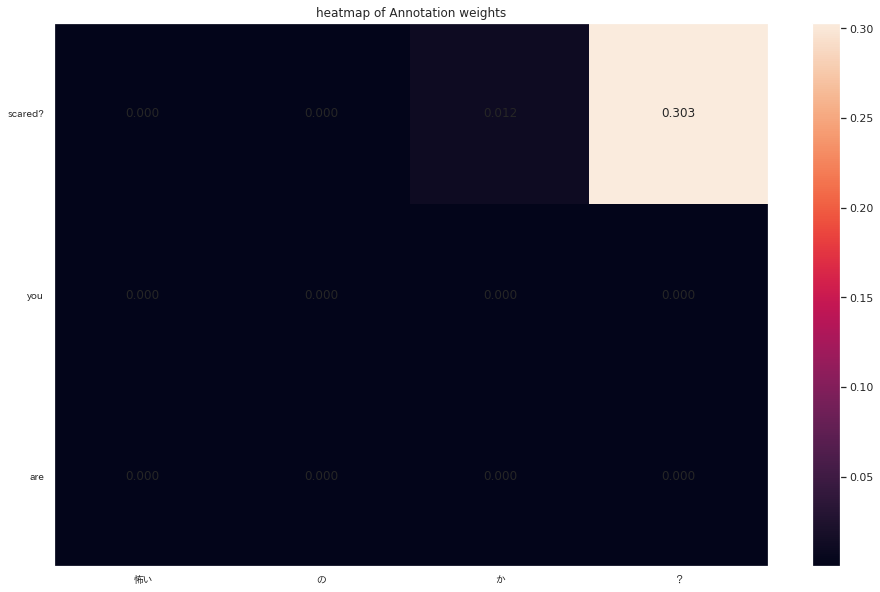

In [74]:
# ... asks Orochimaru! 🐍
model.test('怖いのか？')

<img src="https://i.ibb.co/W3TDNTj/Naruto-Cinco-cosas-que-el-anime-mejoro-en-relacion-al-manga-6-1.jpg" alt="Naruto-Cinco-cosas-que-el-anime-mejoro-en-relacion-al-manga-6-1" border="0">

input sentence: 怖く ない ！
predicted translation: i am not afraid. 


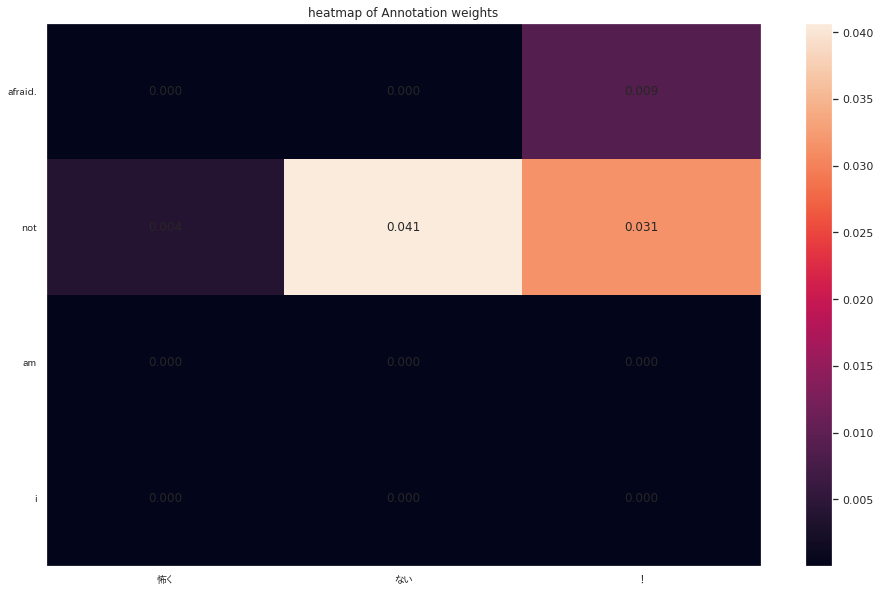

In [83]:
# ... says Naruto! 🦊
model.test('怖くない！')

<img src="https://i.ibb.co/YWXcL6v/itachi.jpg" alt="itachi" border="0">

input sentence: 彼ら が それ を 失わ ない 限り 、 何 か の 真 の 価値 を 実現 し ない こと は 人間 の です 。
predicted translation: it is a thing they are trying to tell the truth they are trying to tell the truth they are trying to tell the truth they are trying to tell the truth they are trying to tell the truth they are trying to tell the truth they are trying 


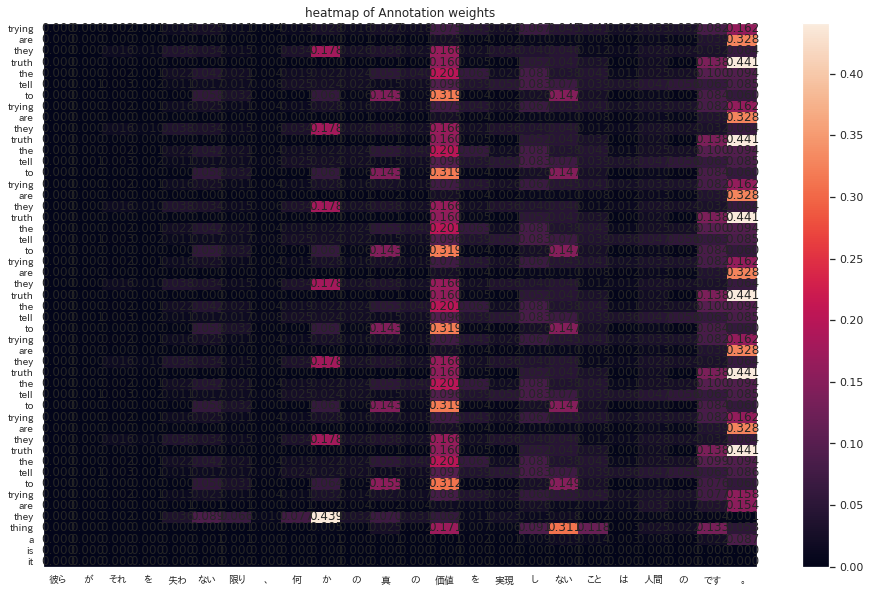

In [94]:
# Finally, *a long dialogue by* Itachi! 🔴
model.test('彼らがそれを失わない限り、何かの真の価値を実現しないことは人間の本性です。')

### The model seems to perform pretty good on short sentences but seems lost while translating long sentences, probably because of the small dataset.
### In the future version I'll improve the performance of this model by adding more data and by some fine-tuning. I'll also use the other scoring functions and see which one works the best.
### Thanks for reading, hope the notebook was useful! Comments and feedbacks are most welcomed!
### Stay strong! Keep on learning!
### さようなら！☮